In [1]:
#!/usr/bin/env python3
import torch
import math
from torch import nn, Tensor
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from typing import Tuple
from matplotlib import pyplot as plt

import combinators.trace.utils as trace_utils
from combinators.trace.utils import RequiresGrad
from combinators.tensor.utils import autodevice, kw_autodevice, copy, show
from combinators.densities import MultivariateNormal, Tempered, RingGMM, Normal
from combinators.densities.kernels import MultivariateNormalKernel, MultivariateNormalLinearKernel, NormalLinearKernel
from combinators.nnets import ResMLPJ
from combinators.objectives import nvo_rkl, nvo_avo
from combinators import Forward, Reverse, Propose
from combinators.stochastic import RandomVariable, ImproperRandomVariable
from combinators.metrics import effective_sample_size, log_Z_hat
import visualize as V

def mk_kernel(from_:int, to_:int, std:float, num_hidden:int, learn_cov=True):
    embedding_dim = 2
    return MultivariateNormalKernel(
        ext_from=f'g{from_}',
        ext_to=f'g{to_}',
        loc=torch.zeros(2, **kw_autodevice()),
        cov=torch.eye(2, **kw_autodevice())*std**2,
        learn_cov=learn_cov,
        net=ResMLPJ(
            dim_in=2,
            dim_hidden=num_hidden,
            dim_out=embedding_dim).to(autodevice()))

def mk_mnlinear_kernel(from_:int, to_:int, std:float, dim:int):
    return MultivariateNormalLinearKernel(
        ext_from=f'g{from_}',
        ext_to=f'g{to_}',
        loc=torch.zeros(dim, **kw_autodevice()),
        cov=torch.eye(dim, **kw_autodevice())*std**2)

def mk_nlinear_kernel(from_:int, to_:int, std:float, dim:int):
    return NormalLinearKernel(ext_from=f'g{from_}', ext_to=f'g{to_}')

def anneal_to_ring(num_targets, n=2):
    g0, gK = mk_ring(num_targets, n)
    return anneal_between(g0, gK, num_targets)

def mk_ring(num_targets, n):
    assert n > 1
    g0 = mk_mvn(0, 0, std=5)
    gK = RingGMM(loc_scale=10, scale=0.5, count=8 if n == "paper" else n, name=f"g{num_targets - 1}").to(autodevice())
    return g0, gK

def anneal_between(left, right, total_num_targets):
    proposal_std = total_num_targets

    # Make an annealing path
    betas = torch.arange(0., 1., 1./(total_num_targets - 1))[1:] # g_0 is beta=0
    path = [Tempered(f'g{k}', left, right, beta) for k, beta in zip(range(1,total_num_targets-1), betas)]
    path = [left] + path + [right]

    assert len(path) == total_num_targets # sanity check that the betas line up
    return path


def anneal_between_mvns(left_loc, right_loc, total_num_targets):
    g0 = mk_mvn(0, left_loc)
    gK =  mk_mvn(total_num_targets-1, right_loc)

    return anneal_between(g0, gK, total_num_targets)

def anneal_between_ns(left_loc, right_loc, total_num_targets):
    g0 = mk_n(0, left_loc)
    gK =  mk_n(total_num_targets-1, right_loc)

    return anneal_between(g0, gK, total_num_targets)

def mk_mvn(i, loc, std=1):
    return MultivariateNormal(name=f'g{i}', loc=torch.ones(2, **kw_autodevice())*loc, cov=torch.eye(2, **kw_autodevice())*std**2)

def mk_n(i, loc):
    return Normal(name=f'g{i}', loc=torch.ones(1, **kw_autodevice())*loc, scale=torch.ones(1, **kw_autodevice())**2)

def mk_model(num_targets:int):
    return dict(
        targets=anneal_to_ring(num_targets, n=8),
        forwards=[mk_kernel(from_=i, to_=i+1, std=1., num_hidden=64) for i in range(num_targets-1)],
        reverses=[mk_kernel(from_=i+1, to_=i, std=1., num_hidden=64) for i in range(num_targets-1)],

#         targets=anneal_between_mvns(0, num_targets*2, num_targets),
#         forwards=[mk_kernel(from_=i, to_=i+1, std=1., num_hidden=64) for i in range(num_targets-1)],
#         reverses=[mk_kernel(from_=i+1, to_=i, std=1., num_hidden=64) for i in range(num_targets-1)],

#         targets=anneal_between_mvns(0, num_targets*2, num_targets),
#         forwards=[mk_mnlinear_kernel(from_=i, to_=i+1, std=1., dim=2) for i in range(num_targets-1)],
#         reverses=[mk_mnlinear_kernel(from_=i+1, to_=i, std=1., dim=2) for i in range(num_targets-1)],

        # NOTES: Anneal between 2 1d guassians with a linear kernel: 2 steps
        # annealing does not learn the forward kernel in the first step, but learns both in the second step. 
#         targets=anneal_between_ns(0, num_targets*2, num_targets),
#         forwards=[mk_nlinear_kernel(from_=i, to_=i+1, std=1., dim=1) for i in range(num_targets-1)],
#         reverses=[mk_nlinear_kernel(from_=i+1, to_=i, std=1., dim=1) for i in range(num_targets-1)],

#         targets=[mk_mvn(i, i*2) for i in range(num_targets)],
#         forwards=[mk_kernel(from_=i, to_=i+1, std=1., num_hidden=32) for i in range(num_targets-1)],
#         reverses=[mk_kernel(from_=i+1, to_=i, std=1., num_hidden=32) for i in range(num_targets-1)],

#         targets=[mk_mvn(i, i*2) for i in range(num_targets)],
#         forwards=[mk_mnlinear_kernel(from_=i, to_=i+1, std=1., dim=2) for i in range(num_targets-1)],
#         reverses=[mk_mnlinear_kernel(from_=i+1, to_=i, std=1., dim=2) for i in range(num_targets-1)],

        # NOTES: With 1 intermediate density between 2 1d guassians with a linear kernel everything is fine
#         targets=[mk_n(i, i*2) for i in range(num_targets)],
#         forwards=[mk_nlinear_kernel(from_=i, to_=i+1, std=1., dim=1) for i in range(num_targets-1)],
#         reverses=[mk_nlinear_kernel(from_=i+1, to_=i, std=1., dim=1) for i in range(num_targets-1)],
    )
K = 8

mk_model(K)

{'targets': [[g0]MultivariateNormal(),
  [β=0.1429][g1]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [β=0.2857][g2]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [β=0.4286][g3]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [β=0.5714][g4]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [β=0.7143][g5]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [β=0.8571][g6]Tempered(
    (density1): [g0]MultivariateNormal()
    (density2): [g7]RingGMM()
  ),
  [g7]RingGMM()],
 'forwards': [MultivariateNormalKernel(
    (net): ResMLPJ(
      (joint): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
      )
      (mu): Sequential(
        (0): Linear(in_features=64, out_features=2, bias=True)
      )
      (cov): Sequential(
        (0): Linear(in_features=6

In [2]:
import torch
import math
from torch import nn, Tensor
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from typing import Tuple
from matplotlib import pyplot as plt

import combinators.trace.utils as trace_utils
from combinators.tensor.utils import autodevice, kw_autodevice
from combinators.densities import MultivariateNormal, Tempered, RingGMM
from combinators.densities.kernels import MultivariateNormalKernel
from combinators.nnets import ResMLPJ
from combinators.objectives import nvo_rkl
from combinators import Forward, Reverse, Propose
from combinators.stochastic import RandomVariable, ImproperRandomVariable
from combinators.metrics import effective_sample_size, log_Z_hat
import visualize as V

In [3]:
#from main import mk_model, mk_kernel
from tqdm.notebook import trange, tqdm


In [4]:
from combinators import Forward

def sample_along(proposal, kernels, sample_shape=(2000,)):
    samples = []
    tr, out = proposal(sample_shape=sample_shape)
    samples.append(out)
    for k in forwards:
        proposal = Forward(k, proposal)
        tr, out = proposal(sample_shape=sample_shape)
        samples.append(out)
    return samples

In [5]:
# main() arguments
seed=1
eval_break = 50

In [6]:
# Setup
torch.manual_seed(seed)
num_samples = 256
sample_shape=(num_samples,)

# Models
out = mk_model(K)
targets, forwards, reverses = [[m.to(autodevice()) for m in out[n]] for n in ['targets', 'forwards', 'reverses']]

assert all([len(list(k.parameters())) >  0 for k in [*forwards, *reverses]])

# logging
writer = SummaryWriter()
loss_ct, loss_sum, loss_avgs, loss_all = 0, 0.0, [], []

In [7]:
print(targets)

[[g0]MultivariateNormal(), [β=0.1429][g1]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [β=0.2857][g2]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [β=0.4286][g3]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [β=0.5714][g4]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [β=0.7143][g5]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [β=0.8571][g6]Tempered(
  (density1): [g0]MultivariateNormal()
  (density2): [g7]RingGMM()
), [g7]RingGMM()]


In [8]:
print(forwards)

# _ = [print(p) for f in forwards  for p in f.parameters()]

[MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
), MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
), MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bia

In [9]:
print(reverses)

# _ = [print(p) for f in reverses for p in f.parameters()]

[MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
), MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
  )
), MultivariateNormalKernel(
  (net): ResMLPJ(
    (joint): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
    )
    (cov): Sequential(
      (0): Linear(in_features=64, out_features=2, bia

In [10]:
from combinators.objectives import mb0, mb1, _estimate_mc, eval_nrep
optimizer = torch.optim.Adam([dict(params=x.parameters()) for x in [*forwards, *reverses]], lr=1e-3)
lazy_i, i = 0, 0

In [ ]:
num_iterations=5000
lazy_i = i
with trange(num_iterations) as bar:
    for i in bar:
        optimizer.zero_grad()

        i += lazy_i
        q0 = targets[0]
        p_prv_tr, out0 = q0(sample_shape=sample_shape)

        loss = torch.zeros(1, **kw_autodevice())
        lw, lvss = torch.zeros(sample_shape, **kw_autodevice()), []
        for k, (fwd, rev, q, p) in enumerate(zip(forwards, reverses, targets[:-1], targets[1:])):
            q.with_observations(trace_utils.copytrace(p_prv_tr, detach=p_prv_tr.keys()))
            q_ext = Forward(fwd, q, _step=k)
            p_ext = Reverse(p, rev, _step=k)
            extend = Propose(target=p_ext, proposal=q_ext, _step=k)
#             breakpoint()
            state, lv = extend(sample_shape=sample_shape, sample_dims=0)

            p_prv_tr = state.target.trace
            p.clear_observations()
            q.clear_observations()
            lw += lv
#             loss += nvo_rkl(lw, lv, state.proposal.trace[f'g{k}'], state.target.trace[f'g{k+1}'])

            loss += nvo_avo(lv)
s
# # # # #             breakpoint()s
#             batch_dim=None
#             sample_dims=0
#             rv_proposal=state.proposal.trace[f'g{k}']
#             rv_target=state.target.trace[f'g{k+1}']
#             # TODO: move back from the proposal and target RVs to joint logprobs?
#             reducedims = (sample_dims,)

#             lw = lw.detach()
#             ldZ = lv.detach().logsumexp(dim=sample_dims) - math.log(lv.shape[sample_dims])
#             f = -lv

#             # rv_proposal = next(iter(proposal_trace.values())) # tr[\gamma_{k-1}]
#             # rv_target = next(iter(target_trace.values()))     # tr[\gamma_{k}]

#             kwargs = dict(
#                 sample_dims=sample_dims,
#                 reducedims=reducedims,
#                 keepdims=False
#             )

#             baseline = _estimate_mc(f.detach(), lw, **kwargs).detach()

#             kl_term = _estimate_mc(mb1(rv_proposal.log_prob.squeeze()) * (f - baseline), lw, **kwargs)

#             grad_log_Z1 = _estimate_mc(rv_proposal.log_prob.squeeze(), lw, **kwargs)
#             grad_log_Z2 = _estimate_mc(eval_nrep(rv_target).log_prob.squeeze(), lw+lv.detach(), **kwargs)
#            #s breakpoint()

#             if k==0:
# #                 loss += kl_term + mb0(baseline * grad_log_Z1 - grad_log_Z2) + baseline + ldZ
#                 loss += nvo_avo(lv)

            lvss.append(lv)
        loss.backward()

        optimizer.step()
#         scheduler.step()

        with torch.no_grad():
            # REPORTING
            # ---------------------------------------
#             # ESS
            lvs = torch.stack(lvss, dim=0)
            lws = torch.cumsum(lvs, dim=1)
            ess = effective_sample_size(lws, sample_dims=-1)
            for step, x in zip(range(1,len(ess)+1), ess):
                writer.add_scalar(f'ess/step-{step}', x, i)

            # logZhat
            lzh = log_Z_hat(lws, sample_dims=-1)
            for step, x in zip(range(1,len(lzh)+1), lzh):
                writer.add_scalar(f'log_Z_hat/step-{step}', x, i)

            # loss
            loss_ct += 1
            loss_scalar = loss.detach().cpu().mean().item()
            writer.add_scalar('loss', loss_scalar, i)
            loss_sum += loss_scalar

            # progress bar
            if i % 10 == 0:
                loss_avg = loss_sum / loss_ct
                loss_template = 'loss={}{:.4f}'.format('' if loss_avg < 0 else ' ', loss_avg)
                logZh_template = 'logZhat[-1]={:.4f}'.format(lzh[-1].cpu().item())
                ess_template = 'ess[-1]={:.4f}'.format(ess[-1].cpu().item())
                loss_ct, loss_sum  = 0, 0.0
                bar.set_postfix_str("; ".join([loss_template, ess_template, logZh_template]))

#             show samples
            if i % (eval_break + 1) == 0:
                samples = sample_along(targets[0], forwards)
                fig = V.scatter_along(samples)
                writer.add_figure('overview', fig, global_step=i, close=True)
#                 for ix, xs in enumerate(samples):
#                     writer.add_figure(f'step-{ix+1}', V.scatter(xs), global_step=i, close=True)



  0%|          | 0/50000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

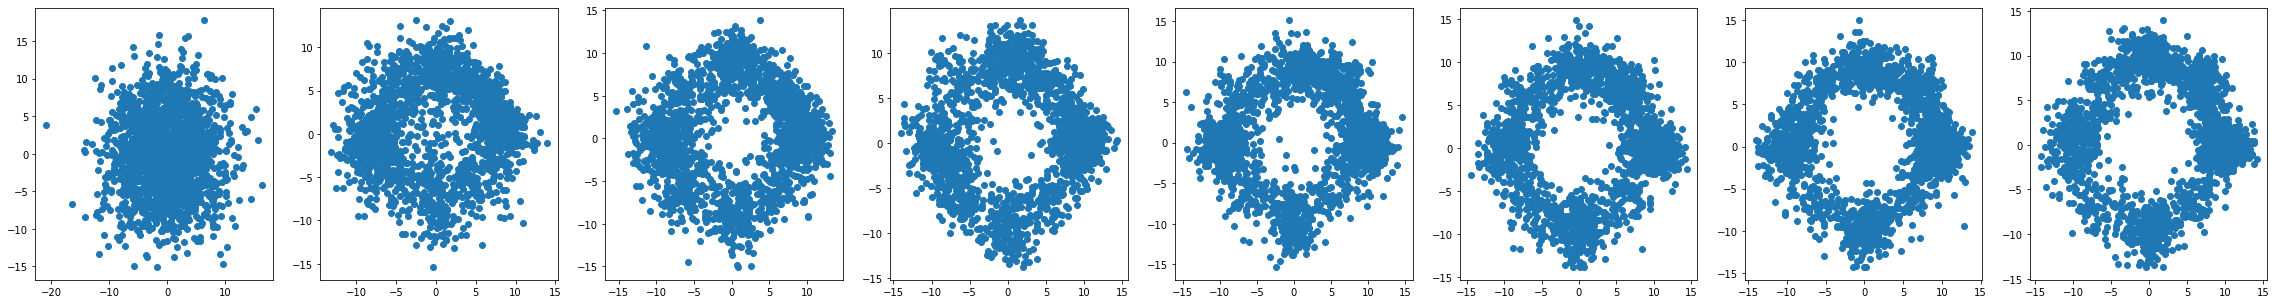

In [12]:
samples = sample_along(targets[0], forwards)
plot_type = len(samples[0].squeeze().shape)

import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.interpolate import interpn
from matplotlib import cm
import matplotlib.gridspec as gridspec

def scatter(xs, lws=None, c='C0', ax=None, show=False):
    xs = xs.squeeze().detach().cpu().numpy()
    assert len(xs.shape) == 2
    inplace = ax is not None
    cm_endpoints = [(i, (*colors.to_rgb(c), i)) for i in [0.0, 1.0]]
    lin_alpha = colors.LinearSegmentedColormap.from_list('incr_alpha', cm_endpoints)
    fig = None
    plt.scatter(*xs.T, c=None, cmap=lin_alpha)

    if show:
        plt.show()
    return fig if fig is not None else ax

def scatter_together(samples):
    fig = plt.figure(figsize=(5*len(samples), 5))
    gspec = gridspec.GridSpec(ncols=len(samples), nrows=1, figure=fig)

    for i, xs in enumerate(samples):
        ax = fig.add_subplot(gspec[0, i])
        scatter(xs)
    return fig

if plot_type == 1:
    print(";  ".join(["{:.4f}".format(ss.mean().cpu().item()) for ss in samples]))
elif plot_type == 2:
    fig = scatter_together(samples)
    plt.show()